In [233]:
import numpy as np
import os, glob
import matplotlib.pyplot as plt

import h5py
import sys
sys.path.append('../')
import analysis_utils as utils

yale_colors = ['#00356b', '#286dc0', '#63aaff', '#4a4a4a']
utils.load_plotting_setting()

import importlib
importlib.reload(utils)

from matplotlib.ticker import LogLocator, NullFormatter, MultipleLocator
from scipy.optimize import curve_fit

In [208]:
from datetime import datetime

def plot_rates(sphere, dataset, data_prefix, n_file, bc, rates, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 5))

    ax.plot(bc, rates[0], '-', color=yale_colors[0], label='All', alpha=1)
    ax.plot(bc, rates[1], '-', color=yale_colors[1], label='Detection quality cut', alpha=1)
    ax.plot(bc, rates[2], '-', color=yale_colors[2], label='Detection quality + noise cut', alpha=1)
    ax.plot(bc, rates[3], '-', color=yale_colors[3], label='Detection quality + noise + anti-coincidence cut', alpha=1)

    ax.set_yscale('log')
    ax.set_xlim(0, 10000)
    ax.set_ylim(1e-8, 500)

In [209]:
sphere = 'sphere_20250103'
datasets = ['20250103_7e-7mbar_alignment0_long',
            '20250104_4e-8mbar_alignment0_long',
            '20250105_2e-8mbar_alignment0_long',
            '20250106_2e-8mbar_8e_alignment0_long',
            '20250107_1e-8mbar_8e_alignment0_long',
            '20250108_1e-8mbar_8e_alignment0_long',
            '20250109_1e-8mbar_8e_alignment1_long',
            '20250110_1e-8mbar_8e_alignment1_long',
            '20250111_1e-8mbar_8e_alignment1_long',
            '20250112_9e-9mbar_8e_alignment1_long',
            '20250113_5e-8mbar_8e_alignment1_long',
            '20250114_1e-8mbar_1e_alignment1_long',
            '20250115_8e-9mbar_0e_alignment1_long',
            '20250116_8e-9mbar_0e_alignment1_long_wrong_lo',
            '20250117_8e-9mbar_0e_alignment1_long',
            '20250118_8e-9mbar_1e_alignment1_long',
            '20250120_8e-9mbar_1e_alignment1_long_wbackscat',
            '20250121_8e-9mbar_1e_alignment1_long',
            '20250122_8e-9mbar_1e_alignment1_long',
            '20250123_7e-9mbar_1e_alignment1_long',
            '20250124_7e-9mbar_1e_alignment1_long',
            '20250125_7e-9mbar_1e_alignment1_long'    
           ]

data_prefixs = ['20250103_d_',
                '20250104_d_',
                '20250105_d_',
                '20250106_d_',
                '20250107_d_',
                '20250108_d_',
                '20250109_d_',
                '20250110_d_',
                '20250111_d_',
                '20250112_d_',
                '20250113_d_',
                '20250114_d_',
                '20250115_d_',
                '20250116_d_',
                '20250117_d_',
                '20250118_d_',
                '20250119_d_',
                '20250120_d_',
                '20250121_d_',
                '20250122_d_',
                '20250123_d_',
                '20250124_d_',
                '20250125_d_',
                ]

n_files = [1440, 1440, 900, 1440, 1440, 1440, 1440, 1440, 1440, 780, 1440, 1440, 1440, 1440, 1440, 1983, 1463, 1440, 1440, 1440, 1440, 1121]

bc, scaling = None, None
hhs, rates, n_windows = [], [], []
for i, dataset in enumerate(datasets):
    data_dir = f'/Users/yuhan/work/nanospheres/data/dm_data_processed/{sphere}/{dataset}'
    
    _bc, _hhs, _rates, _n, _scaling = utils.get_summed_rates(data_dir, dataset)
    hhs.append(_hhs)
    rates.append(_rates)
    n_windows.append(_n)

    if bc is None:
        bc = _bc
    if scaling is None:
        scaling = _scaling


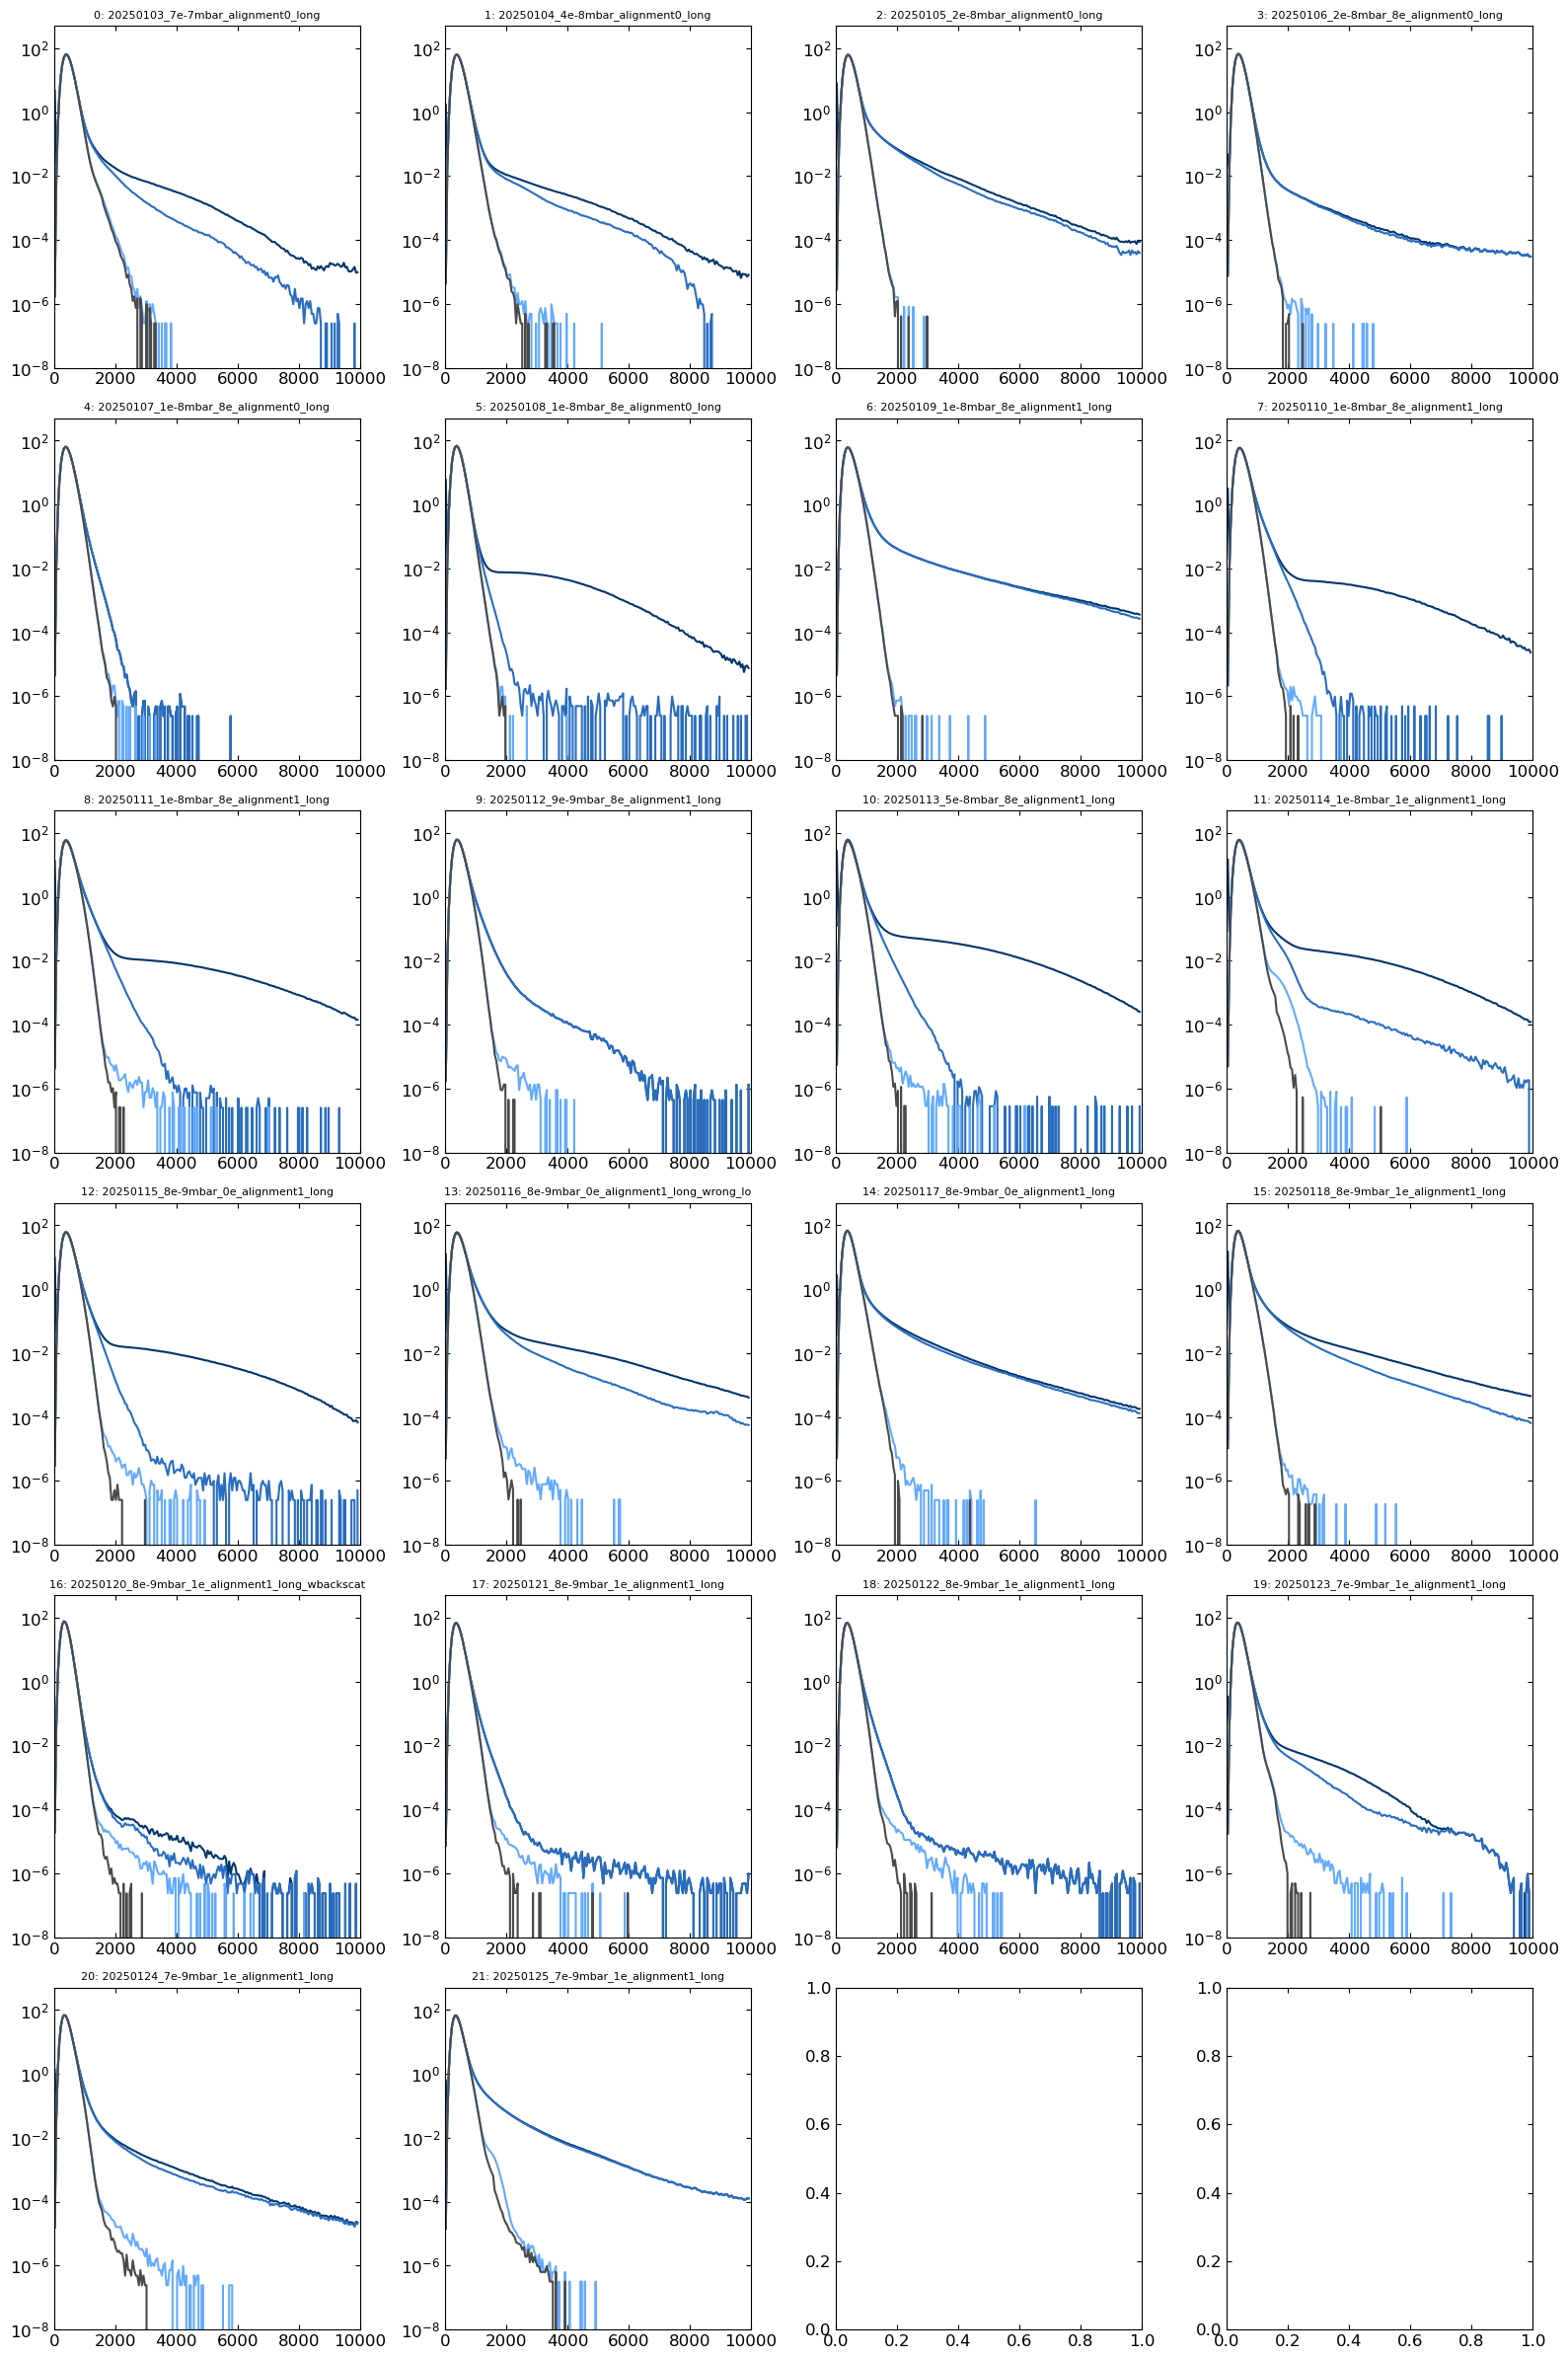

In [210]:
fig, axes = plt.subplots(6, 4, figsize=(16, 24))

for i in range(len(datasets)):
    ax = axes.flatten()[i]
    plot_rates(sphere, datasets[i], data_prefixs[i], n_files[i], bc, rates[i], ax)
    ax.set_title(f'{i}: {datasets[i]}', fontsize=8)

axes[0]
fig.tight_layout()

Text(0, 0.5, 'Differential count (Hz/keV)')

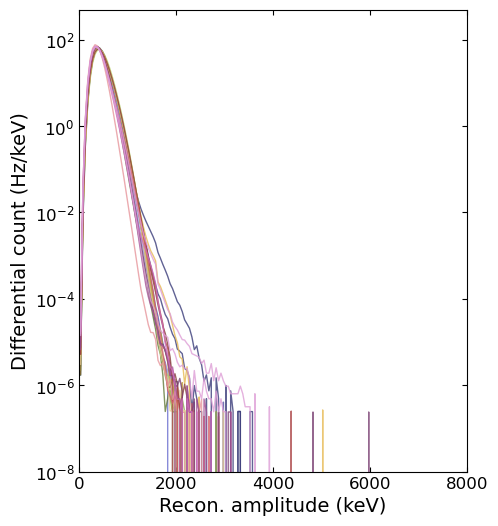

In [211]:
colors = plt.colormaps.get_cmap('tab20b').resampled(len(datasets)).colors
fig, ax = plt.subplots(figsize=(5, 6))

n_search_per_win = (5000 - 150) / 25
time_per_search = 2e-6 * 25
scaling = n_search_per_win * time_per_search * 50  # because of the 50 keV bins

times = [n[-1] * n_search_per_win * time_per_search / 3600 for n in n_windows] # Time in hours for each dataset (aftercut)

for i in range(len(datasets)):
    # if i < 11: continue
    ax.plot(bc, rates[i][-1], '-', color=colors[i], label=f'Dataset {i} ({times[i]:.1f} hours)', alpha=0.8, linewidth=1)

# ax.legend(frameon=False, fontsize=12)

ax.set_yscale('log')
# ax.set_xscale('log')
ax.set_xlim(0, 8000)
ax.set_ylim(1e-8, 500)

ax.set_xlabel('Recon. amplitude (keV)')
ax.set_ylabel('Differential count (Hz/keV)')

In [212]:
from scipy.special import erf
def gaus(x, x0, sigma):
    return (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-1 * (x - x0)**2 / (2 * sigma**2))

cal_file = '/Users/yuhan/work/nanospheres/data/pulse_calibration_processed/sphere_20250103_calibration_all.h5py'
with h5py.File(cal_file, 'r') as fout:
    amp2kev = fout['calibration_data_processed'].attrs['amp2kev']
    search_bias = fout['calibration_data_processed'].attrs['search_bias_kev']
    sigma_p = fout['calibration_data_processed'].attrs['sigma_p_kev']
    eff_params = fout['calibration_data_processed']['sig_efficiency_fit_params'][:]

In [219]:
def func2(x, z, f):
    return 0.5 * erf((x - z) * f) + 0.5

eff_hist = func2(bc, *eff_params)

In [238]:
from scipy.special import erf

def gaus(x, mu, sigma):
    return (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-1 * (x - mu)**2 / (2 * sigma**2))

def mod_gaus_search_bias(xx, amp, bias, sigma):
    xx = np.asarray(xx)

    half_gaus = 2 * gaus(xx, 0, sigma)
    area_below_bias = 2 * (0.5 + 0.5 * erf(bias / (np.sqrt(2) * sigma)))

    half_gaus[xx < bias] = 0

    gaus_term = gaus(xx, bias, sigma)
    gaus_tail = gaus_term[xx > 2 * bias]

    gaus_term[0:gaus_tail.size] += gaus_tail

    return amp * (gaus_term * area_below_bias + half_gaus)

def skewnorm(x, amp, mu, sigma, alpha):
    gaus_term = 1 / (np.sqrt(2 * np.pi) * sigma) * np.exp(-1 * (x - mu)**2 / (2 * sigma**2))

    x_prime = (x - mu / sigma)
    erf_term  = 0.5 * (1 + erf(alpha * x_prime / np.sqrt(2)))
    
    return amp * 2 * gaus_term * erf_term

<>:22: SyntaxWarning: invalid escape sequence '\s'
<>:22: SyntaxWarning: invalid escape sequence '\s'
/var/folders/mb/1ggr_wms5jz0l7fkkc3b9xg80000gn/T/ipykernel_1845/3543330206.py:22: SyntaxWarning: invalid escape sequence '\s'
  ax.plot(xx, gaus_amp * gaus(xx, 0, *popt), '--', color='#DC3220', label=f'$\sigma$ = {popt[-1]:.1f} keV/c')


Text(0, 0.5, 'Differential count (Hz/keV/c)')

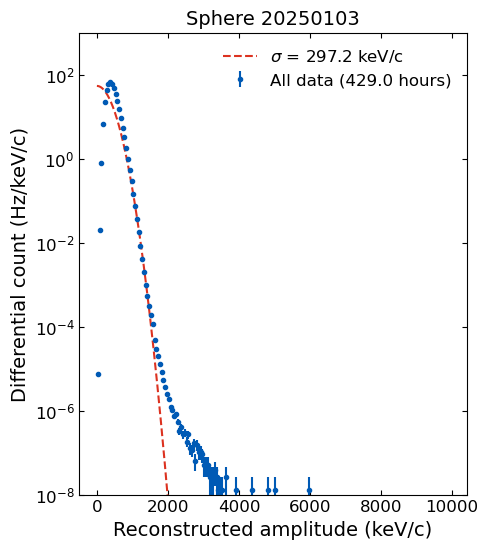

In [298]:
hh_sum = np.sum(np.asarray(hhs[2:]), axis=0)
n_window_sum = np.sum(np.asarray(n_windows[2:]), axis=0)
time_sum = np.sum(np.asarray(times[2:]))

rate_after_cut = hh_sum[3] / (n_window_sum[3] * scaling)

fig, ax = plt.subplots(figsize=(5, 6))
ax.errorbar(bc, rate_after_cut, yerr=np.sqrt(hh_sum[3])/(n_window_sum[3]*scaling), fmt='.', color='#005AB5', label=f'All data ({time_sum:.1f} hours)', alpha=1)

# Factor of 2 because we only have half of a Gaussian
gaus_amp = 2 * 1 / (2e-6 * 25)  # (1 s) / (time per search)

# rate_sum = np.sum(hh_sum[3]/(n_window_sum[3] * scaling))

fit_lb, fit_ub = 1000, 1800
idx_fit = np.logical_and(bc > fit_lb, bc < fit_ub)
popt, pcov = curve_fit(lambda x, sigma : gaus_amp * gaus(x, 0, sigma), 
                       bc[idx_fit], (rate_after_cut)[idx_fit], p0=[280])


xx = np.linspace(0, 3000, 500)
ax.plot(xx, gaus_amp * gaus(xx, 0, *popt), '--', color='#DC3220', label=f'$\sigma$ = {popt[-1]:.1f} keV/c')

ax.legend(frameon=False, fontsize=12)

ax.set_yscale('log')
# ax.set_xscale('log')

# ax.set_xlim(1000, 7000)
ax.set_ylim(1e-8, 1000)

# ax.set_yticks(np.logspace(-8, 3, 12))
# locmin = LogLocator(base=10.0, subs=(0.2, 0.4, 0.6, 0.8), numticks=15)
# ax.xaxis.set_minor_locator(MultipleLocator(500))
# ax.yaxis.set_minor_locator(locmin)
# ax.yaxis.set_minor_formatter(NullFormatter())

ax.set_title('Sphere 20250103')
ax.set_xlabel('Reconstructed amplitude (keV/c)')
ax.set_ylabel('Differential count (Hz/keV/c)')

In [296]:
popt

array([297.21685637])

In [110]:
outfile_name = 'sphere_20250103_recon_all.h5py'
out_dir = '/Users/yuhan/work/nanospheres/data/dm_data_processed/sphere_20250103'

with h5py.File(os.path.join(out_dir, outfile_name), 'w') as fout:
    g = fout.create_group('recon_data_all')
    d = g.create_dataset('bc', data=bc, dtype=np.float64)
    d.attrs['unit'] = 'keV'

    d = g.create_dataset('hist', data=(hh_sum[3]), dtype=np.int64)
    d.attrs['unit'] = 'Count'
    d.attrs['n_windows'] = n_window_sum[3]
    d.attrs['scaling'] = scaling

    d = g.create_dataset('rate_hist', data=(hh_sum[3] / (n_window_sum[3] * scaling)), dtype=np.float64)
    d.attrs['unit'] = 'Hz/keV'

    g.create_dataset('rate_hist_err', data=(np.sqrt(hh_sum[3])/(n_window_sum[3]*scaling)), dtype=np.float64)
    g.attrs['time_hours'] = time_sum

    fout.close()

In [58]:
spheres_other = ['sphere_20241202',
                 'sphere_20241221',
                 'sphere_20241226',
                ] 
datasets_other = ['20241215_9e-9mbar_0e_alignment2_long',
                  '20241222_5e-8mbar_10e_alignment0_long',
                  '20241227_6e-8mbar_alignment0_long',
                ]

data_prefixs_other = ['20251215_d_',
                      '20251222_d_',
                      '20251226_d_',
                ]

n_files_other = [1440, 1031, 1440]

bc_other, scaling_other = None, None
hhs_other, rates_other, n_windows_other = [], [], []

for i, dataset in enumerate(datasets_other):
    data_dir = f'/Users/yuhan/work/nanospheres/data/dm_data_processed/{spheres_other[i]}/{dataset}'
    
    _bc, _hhs, _rates, _n, _scaling = utils.get_summed_rates(data_dir, dataset)
    hhs_other.append(_hhs)
    rates_other.append(_rates)
    n_windows_other.append(_n)

    if bc_other is None:
        bc_other = _bc
    if scaling_other is None:
        scaling_other = _scaling


<>:10: SyntaxWarning: invalid escape sequence '\p'
<>:11: SyntaxWarning: invalid escape sequence '\p'
<>:12: SyntaxWarning: invalid escape sequence '\p'
<>:10: SyntaxWarning: invalid escape sequence '\p'
<>:11: SyntaxWarning: invalid escape sequence '\p'
<>:12: SyntaxWarning: invalid escape sequence '\p'
/var/folders/mb/1ggr_wms5jz0l7fkkc3b9xg80000gn/T/ipykernel_42657/1904331676.py:10: SyntaxWarning: invalid escape sequence '\p'
  axes[1].plot(bc, rates[15][-1], '-', color=colors[7], label=f'($8\pm4) \\times 10^{{-9}}$ mbar', alpha=1)
/var/folders/mb/1ggr_wms5jz0l7fkkc3b9xg80000gn/T/ipykernel_42657/1904331676.py:11: SyntaxWarning: invalid escape sequence '\p'
  axes[1].plot(bc, rates[2][-1], '-', color=colors[2], label=f'($2\pm1) \\times 10^{{-8}}$ mbar', alpha=0.8)
/var/folders/mb/1ggr_wms5jz0l7fkkc3b9xg80000gn/T/ipykernel_42657/1904331676.py:12: SyntaxWarning: invalid escape sequence '\p'
  axes[1].plot(bc, rates[6][-1], '-', color=colors[3], label=f'($5\pm3) \\times 10^{{-8}}$ mbar'

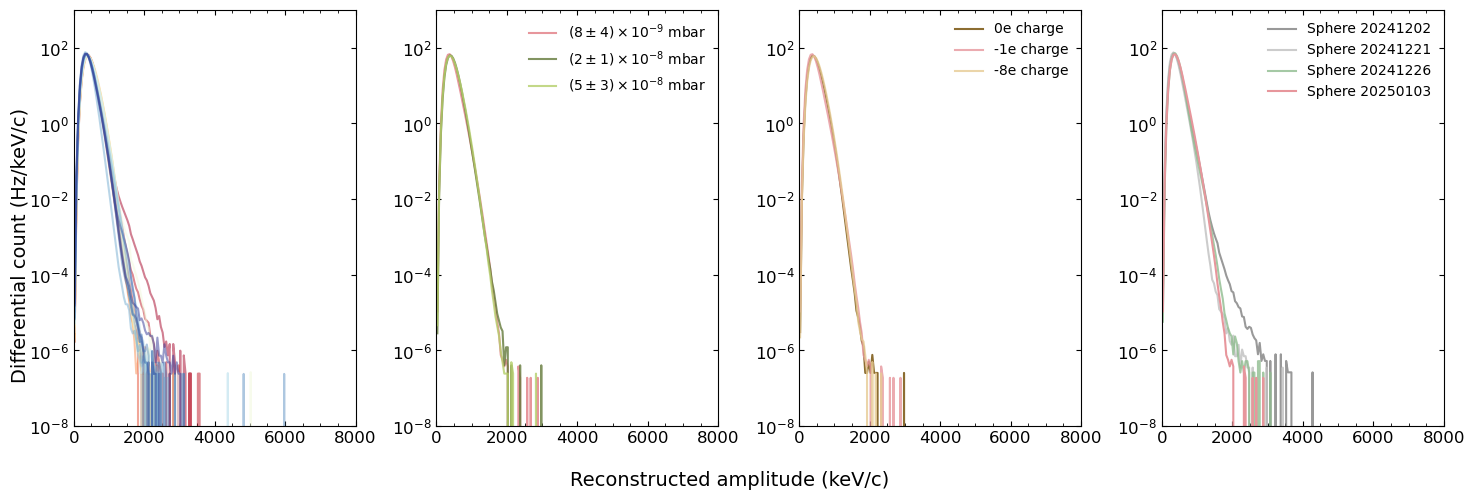

In [114]:
import matplotlib
colors = plt.colormaps.get_cmap('tab20b').resampled(10).colors
colors_day = [matplotlib.colors.rgb2hex(plt.colormaps.get_cmap('RdYlBu')(i)) for i in np.linspace(0, 1, 21)]

fig, axes = plt.subplots(1, 4, figsize=(15, 5))

for i in range(21):
    axes[0].plot(bc, rates[i][-1], '-', color=colors_day[i], alpha=0.5, linewidth=1.5)

axes[1].plot(bc, rates[15][-1], '-', color=colors[7], label=f'($8\pm4) \\times 10^{{-9}}$ mbar', alpha=1)
axes[1].plot(bc, rates[2][-1], '-', color=colors[2], label=f'($2\pm1) \\times 10^{{-8}}$ mbar', alpha=0.8)
axes[1].plot(bc, rates[6][-1], '-', color=colors[3], label=f'($5\pm3) \\times 10^{{-8}}$ mbar', alpha=0.8)

axes[2].plot(bc, rates[12][-1], '-', color=colors[4], label=f'0e charge', alpha=1)
axes[2].plot(bc, rates[15][-1], '-', color=colors[7], label=f'-1e charge', alpha=0.8)
axes[2].plot(bc, rates[7][-1], '-', color=colors[5], label=f'-8e charge', alpha=0.8)

axes[3].plot(bc, rates_other[0][-1], '-', color='grey', label=f'Sphere 20241202', alpha=0.8)
axes[3].plot(bc, rates_other[1][-1], '-', color='silver', label=f'Sphere 20241221', alpha=0.8)
axes[3].plot(bc, rates_other[2][-1], '-', color='darkseagreen', label=f'Sphere 20241226', alpha=0.8)
axes[3].plot(bc, rates[15][-1], '-', color=colors[7], label=f'Sphere 20250103', alpha=1)

for ax in axes.flatten():
    ax.legend(frameon=False, fontsize=10, loc='upper right')
    ax.set_yscale('log')
    ax.minorticks_on()

    ax.set_xlim(0, 8000)
    ax.set_ylim(1e-8, 1000)

fig.supxlabel('Reconstructed amplitude (keV/c)', fontsize=14)
fig.supylabel('Differential count (Hz/keV/c)', fontsize=14)
fig.tight_layout()

In [102]:
data_dir = f'/Users/yuhan/work/nanospheres/data/dm_data_processed/{sphere}/{datasets[21]}'
data_prefix = r'20250125_d_'

hists_21 = utils.load_data_hists(data_dir, data_prefix, n_files[21], 1600)

events_after_cut_21 = utils.get_events_after_cut(hists_21, thr=2000)
print('Number of windows with large events: ', len(events_after_cut_21))

Number of windows with large events:  388


/Volumes/LaCie/dm_data/sphere_20250103/20250125_7e-9mbar_1e_alignment1_long/20250125_d_1068.hdf5
/Volumes/LaCie/dm_data/sphere_20250103/20250125_7e-9mbar_1e_alignment1_long/20250125_d_1069.hdf5
/Volumes/LaCie/dm_data/sphere_20250103/20250125_7e-9mbar_1e_alignment1_long/20250125_d_1080.hdf5
/Volumes/LaCie/dm_data/sphere_20250103/20250125_7e-9mbar_1e_alignment1_long/20250125_d_1083.hdf5
/Volumes/LaCie/dm_data/sphere_20250103/20250125_7e-9mbar_1e_alignment1_long/20250125_d_1084.hdf5
/Volumes/LaCie/dm_data/sphere_20250103/20250125_7e-9mbar_1e_alignment1_long/20250125_d_1089.hdf5
/Volumes/LaCie/dm_data/sphere_20250103/20250125_7e-9mbar_1e_alignment1_long/20250125_d_1089.hdf5
/Volumes/LaCie/dm_data/sphere_20250103/20250125_7e-9mbar_1e_alignment1_long/20250125_d_1090.hdf5
/Volumes/LaCie/dm_data/sphere_20250103/20250125_7e-9mbar_1e_alignment1_long/20250125_d_1092.hdf5
/Volumes/LaCie/dm_data/sphere_20250103/20250125_7e-9mbar_1e_alignment1_long/20250125_d_1095.hdf5


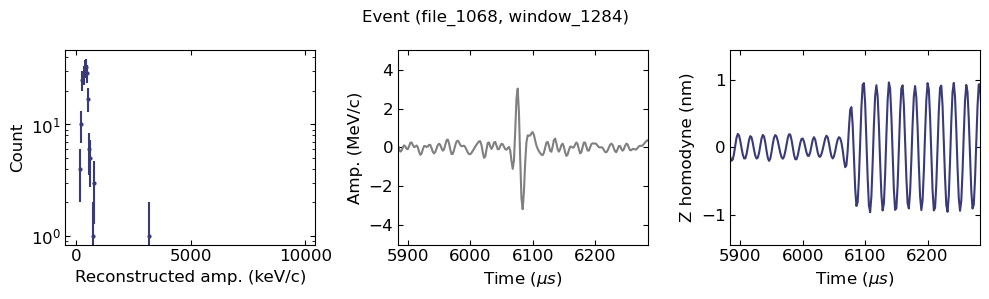

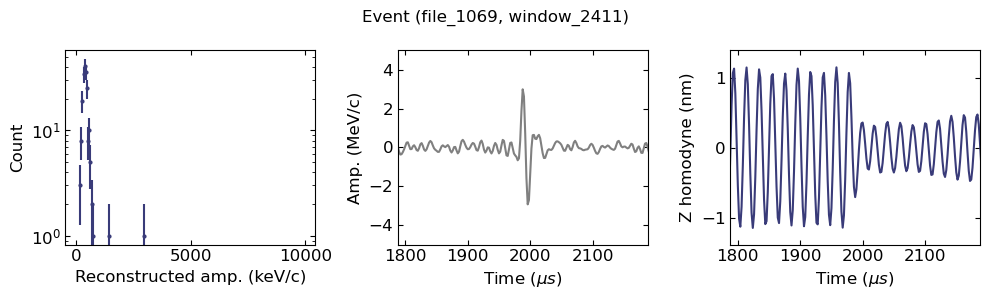

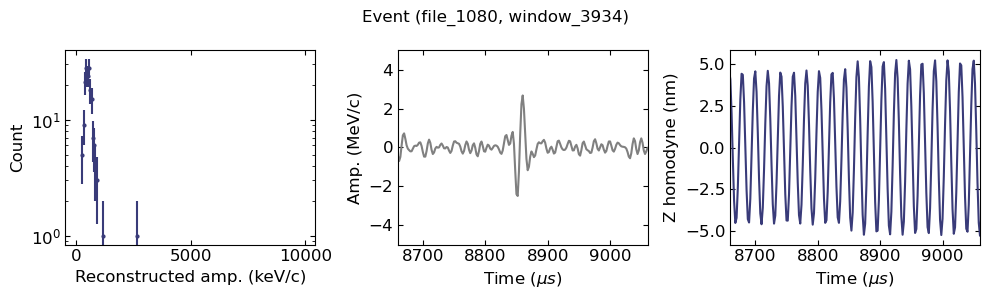

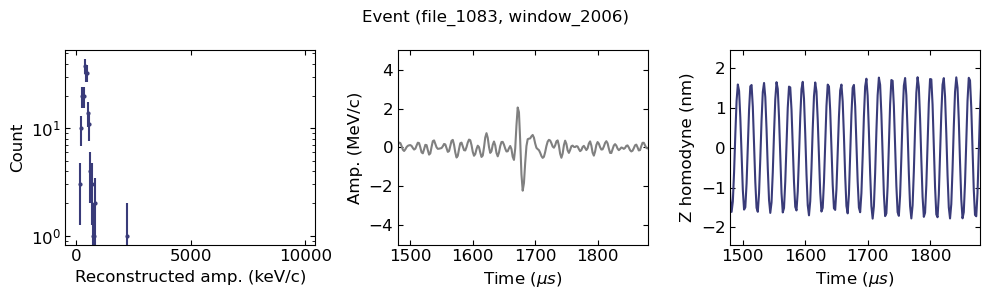

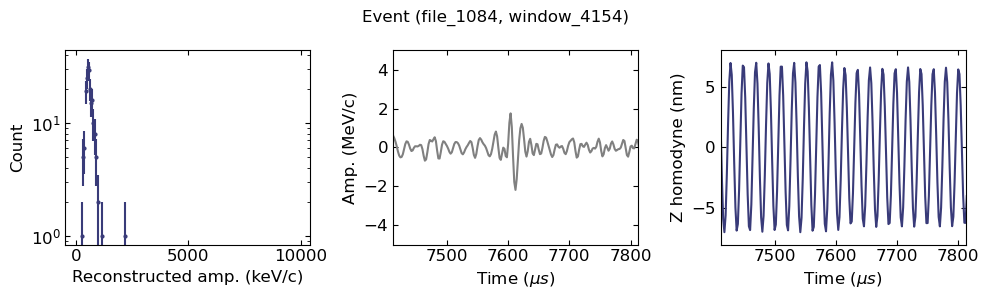

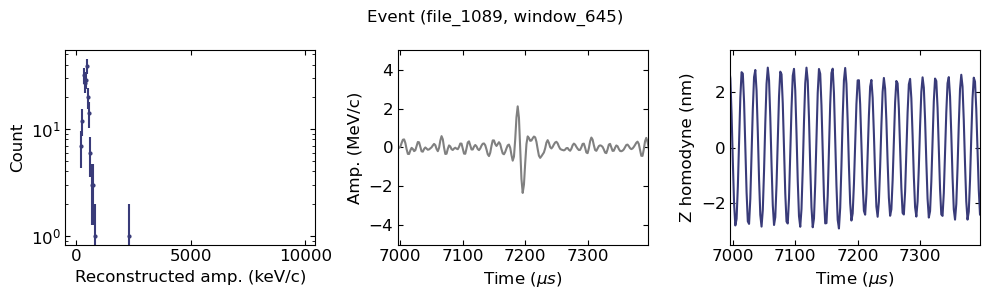

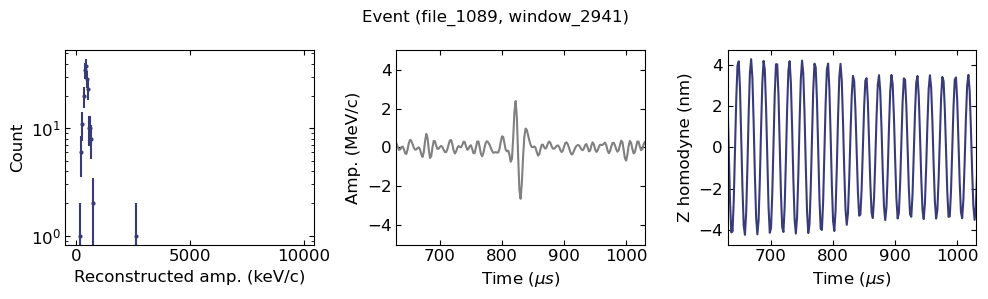

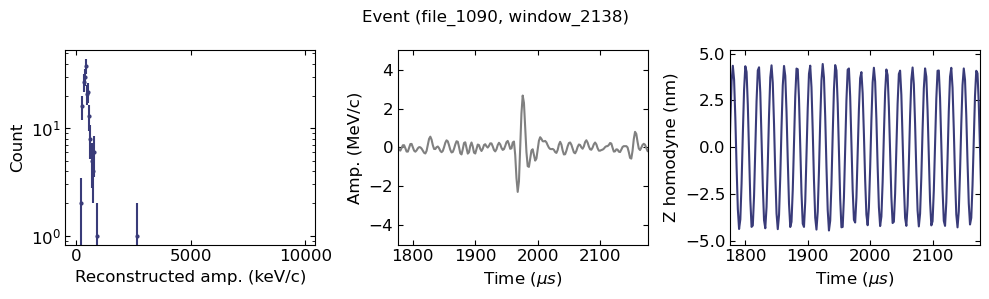

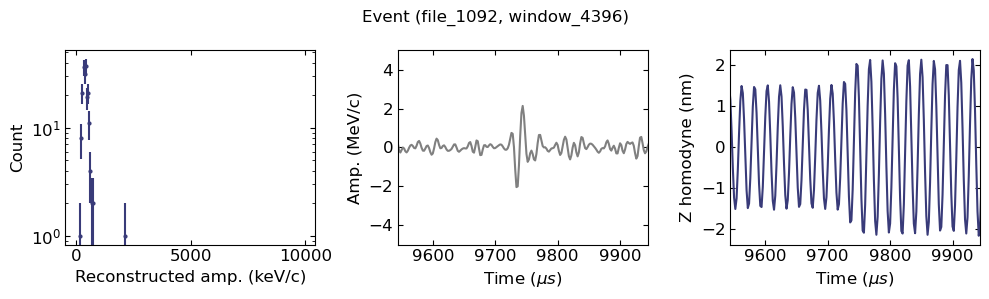

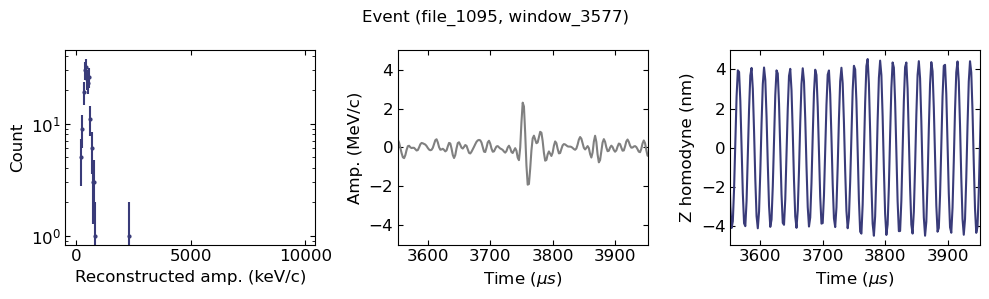

In [106]:
raw_data_dir = rf'/Volumes/LaCie/dm_data/{sphere}/{datasets[21]}'

c_mv = 5.522e-08
amp2kev = 7396.062147743912

window_length = 5000
bins = np.arange(0, 10000, 50)
bc = 0.5 * (bins[:-1] + bins[1:])

for i, j in events_after_cut_21[-20:-10]:
    _, _, _, _, _, _ = utils.plot_hist_events(raw_data_dir, data_prefix, i, j, window_length, bins, bc, c_mv, amp2kev, False, True)

In [66]:
data_dir = f'/Users/yuhan/work/nanospheres/data/dm_data_processed/{sphere}/{datasets[6]}'
data_prefix = r'20250109_d_'

hists_6 = utils.load_data_hists(data_dir, data_prefix, n_files[6], 1600)

events_after_cut_6 = utils.get_events_after_cut(hists_6, thr=2000)
print('Number of windows with large events: ', len(events_after_cut_6))

Number of windows with large events:  5


/Volumes/LaCie/dm_data/sphere_20250103/20250109_1e-8mbar_8e_alignment1_long/20250109_d_308.hdf5
/Volumes/LaCie/dm_data/sphere_20250103/20250109_1e-8mbar_8e_alignment1_long/20250109_d_568.hdf5
/Volumes/LaCie/dm_data/sphere_20250103/20250109_1e-8mbar_8e_alignment1_long/20250109_d_844.hdf5
/Volumes/LaCie/dm_data/sphere_20250103/20250109_1e-8mbar_8e_alignment1_long/20250109_d_1174.hdf5
/Volumes/LaCie/dm_data/sphere_20250103/20250109_1e-8mbar_8e_alignment1_long/20250109_d_1361.hdf5


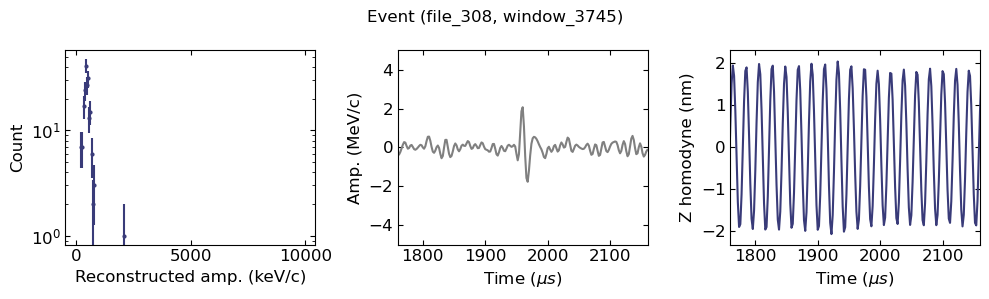

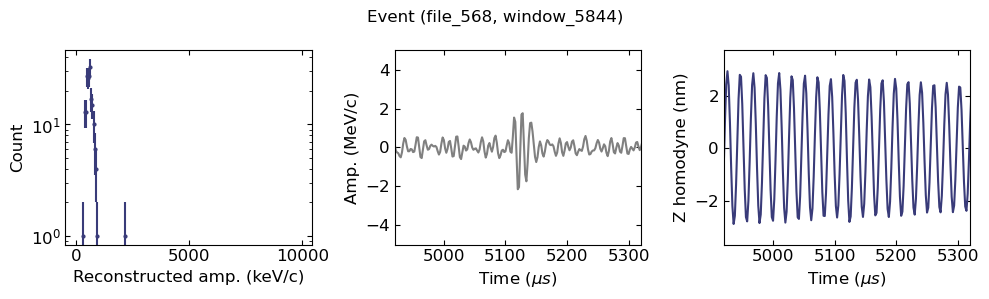

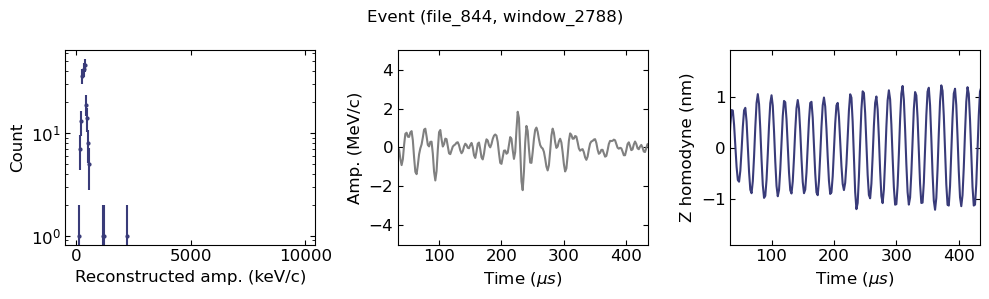

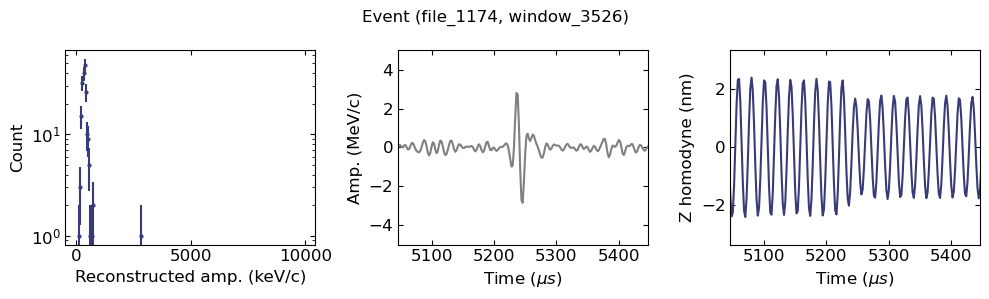

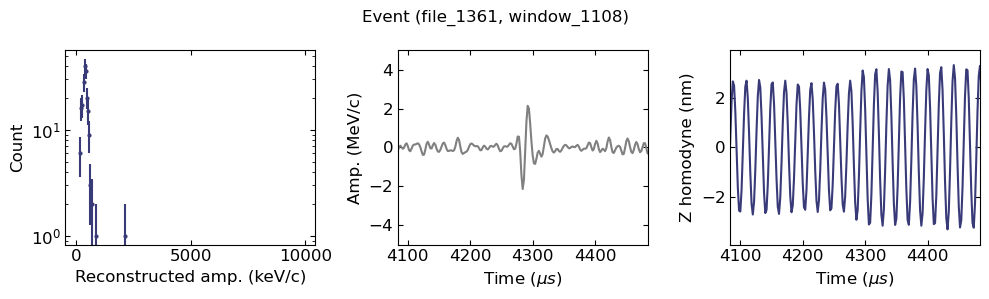

In [67]:
raw_data_dir = rf'/Volumes/LaCie/dm_data/{sphere}/{datasets[6]}'

c_mv = 5.522e-08
amp2kev = 7504.810851477031

window_length = 5000
bins = np.arange(0, 10000, 50)
bc = 0.5 * (bins[:-1] + bins[1:])

for i, j in events_after_cut_6[:]:
    _, _, _, _, _, _ = utils.plot_hist_events(raw_data_dir, data_prefix, i, j, window_length, bins, bc, c_mv, amp2kev, False, True)

In [71]:
data_dir = f'/Users/yuhan/work/nanospheres/data/dm_data_processed/{sphere}/{datasets[11]}'
data_prefix = r'20250114_d_'

hists_11 = utils.load_data_hists(data_dir, data_prefix, n_files[11], 1600, 400)

events_after_cut_11 = utils.get_events_after_cut(hists_11, thr=4000)
print('Number of windows with large events: ', len(events_after_cut_11))

Number of windows with large events:  1


/Volumes/LaCie/dm_data/sphere_20250103/20250114_1e-8mbar_1e_alignment1_long/20250114_d_733.hdf5


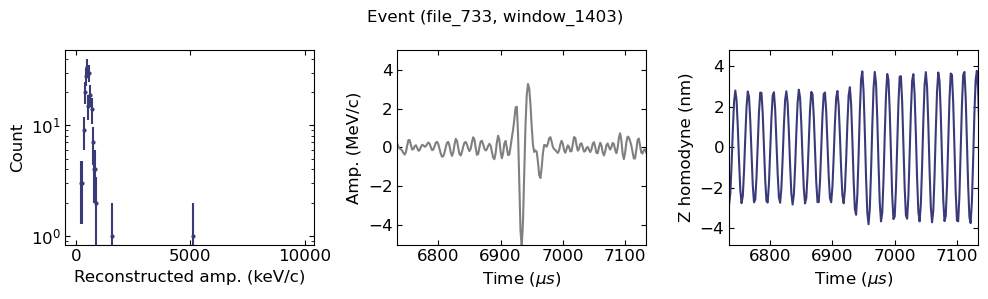

In [72]:
raw_data_dir = rf'/Volumes/LaCie/dm_data/{sphere}/{datasets[11]}'

c_mv = 5.522e-08
amp2kev = 7504.810851477031

window_length = 5000
bins = np.arange(0, 10000, 50)
bc = 0.5 * (bins[:-1] + bins[1:])

for i, j in events_after_cut_11[:]:
    _, _, _, _, _, _ = utils.plot_hist_events(raw_data_dir, data_prefix, i, j, window_length, bins, bc, c_mv, amp2kev, False, True)

#### Look into unsearched spectrum to correct for search bias

In [190]:
def load_histograms(data_dir, data_prefix, n_file):
    bc = None
    hhs, hhs_debiased, hhs_nosearch, good_dets, noise_levels = [], [], [], [], []

    for i in range(n_file):
        file = os.path.join(data_dir, f'{data_prefix}{i}_processed.hdf5')
        f = h5py.File(file, 'r')

        if bc is None:
            bc = f['data_processed'].attrs['bin_center_kev']
        
        hhs.append(f['data_processed']['histogram'][:])
        hhs_debiased.append(f['data_processed']['histogram_debiased'][:])

        hhs_nosearch.append(f['data_processed']['histogram_nosearch'][:])
        good_dets.append(f['data_processed']['good_detection'][:])
        noise_levels.append(f['data_processed']['noise_level_kev'][:])

        f.close()
    
    hhs = np.asarray(hhs)
    hhs_debiased = np.asarray(hhs_debiased)
    hhs_nosearch = np.asarray(hhs_nosearch)
    noise_levels = np.asarray(noise_levels)
    good_dets = np.array(good_dets)

    return bc, hhs, hhs_debiased, hhs_nosearch, good_dets, noise_levels

In [203]:
data_dir = r'/Users/yuhan/work/nanospheres/data/dm_data_processed_w_nosearch/sphere_20250103/20250111_1e-8mbar_8e_alignment1_long/'
data_prefix = '20250111_d_'

excess_thr = 1600
noise_thr = 400
bc, hhs, hhs_debiased, hhs_nosearch, good_dets, noise_levels = load_histograms(data_dir, data_prefix, 5)
good_noise_level = utils.check_noise_level(noise_levels, noise_thr)
no_excess_events = utils.check_excess_event(hhs, bc, thr=excess_thr)

In [204]:
hh_cut_all   = hhs[np.logical_and(np.logical_and(good_dets, good_noise_level), no_excess_events)]
hh_db_cut_all   = hhs_debiased[np.logical_and(np.logical_and(good_dets, good_noise_level), no_excess_events)]
hh_ns_cut_all   = hhs_nosearch[np.logical_and(np.logical_and(good_dets, good_noise_level), no_excess_events)]

hh_cut_all_sum = np.sum(hh_cut_all, axis=0)
hh_db_cut_all_sum = np.sum(hh_db_cut_all, axis=0)
hh_ns_cut_all_sum = np.sum(hh_ns_cut_all, axis=0)



Text(0, 0.5, 'Normalized count / (50 keV/c)')

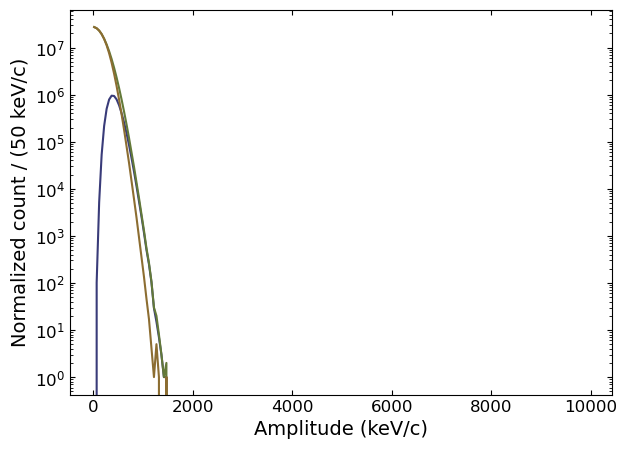

In [291]:
idx_per_search = 25

plt.plot(bc, hh_cut_all_sum, '-')
# plt.plot(bc, hh_db_cut_all_sum, '.-')
plt.plot(bc, hh_ns_cut_all_sum, '-')
plt.plot(bc, hh_ns_cut_all_sum - hh_cut_all_sum, '-')

# xx = np.linspace(0, 3000, 500)
# plt.plot(xx, 640000000 * gaus(xx, 0, 220), '--', color='#DC3220', label=f'$\sigma$ = {sigma} keV/c')

# plt.xlim(500, 1200)
# plt.ylim(1e-2, 1e7)
plt.yscale('log')

plt.xlabel('Amplitude (keV/c)')
plt.ylabel('Normalized count / (50 keV/c)')

In [ ]:
n_mc = int(1e8)
rand_seed = 22040403
rng = np.random.default_rng(rand_seed)

noise_gaussian = rng.normal(0, 200, n_mc)
noise_gaussian_amp = np.abs(noise_gaussian)

In [270]:
noise_reshaped = np.reshape(noise_gaussian_amp, (int(noise_gaussian_amp.size/25), 25))
noise_searched = np.max(noise_reshaped, axis=1)

In [ ]:
bins = np.arange(0, 10000, 50)
bc = 0.5 * (bins[:-1] + bins[1:])

hh_all = np.histogram(noise_gaussian_amp, bins=bins)[0]
hh_searched = np.histogram(noise_searched, bins=bins)[0]

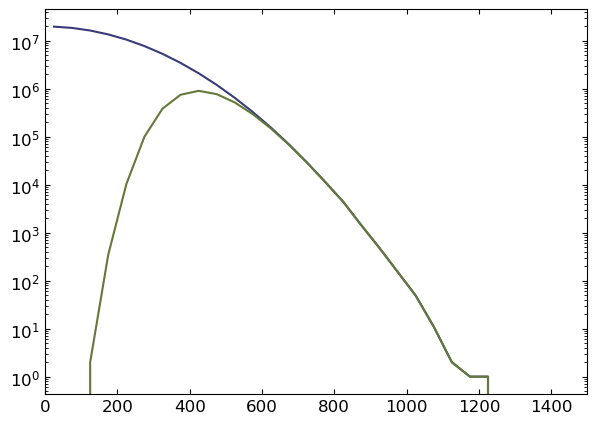

In [285]:
plt.plot(bc, hh_all)
plt.plot(bc, hh_searched)
# plt.plot(bc, hh_all - hh_searched)

plt.xlim(0, 4000)
plt.xlim(0, 1500)
# plt.xscale('log')
plt.yscale('log')